In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [13:46:23] Enabling RDKit 2019.09.3 jupyter extensions


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.492096
epoch: 0, lr: 0.01
train loss: 20689.938621238427, val loss: 16193.5966796875
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:09.371287
epoch: 10, lr: 0.01
train loss: 472.30614104094326, val loss: 572.1247680664062
sklearn train metric: 0, sklearn validation metric: 0
test loss: 389.9271606445312
learning time: 0:00:16.120248
sklearn test metric: 
0 



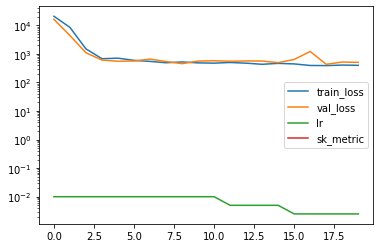

In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.392570
epoch: 0, lr: 0.01
train loss: 1531.3459408408717, val loss: 1502.001953125
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:14.155140
epoch: 5, lr: 0.01
train loss: 74.91171284725792, val loss: 61.71005630493164
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:25.491942
epoch: 10, lr: 0.01
train loss: 34.75180545606111, val loss: 35.639517307281494
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:37.290431
epoch: 15, lr: 0.005
train loss: 35.64917574430767, val loss: 33.610694885253906
sklearn train metric: 0, sklearn validation metric: 0
test loss: 32.02101993560791
learning time: 0:00:47.721344
sklearn test metric: 
0 



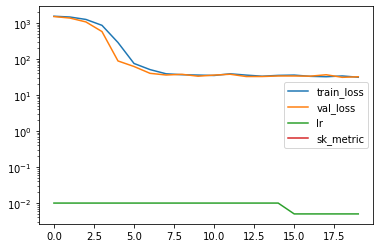

In [5]:
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,None,True)]}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'embeds': ['atoms'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.195440
epoch: 0, lr: 0.01
train loss: 1562.1771368729442, val loss: 1545.3942260742188
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:13.062842
epoch: 5, lr: 0.01
train loss: 523.7241500051398, val loss: 276.8063507080078
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:23.719550
epoch: 10, lr: 0.01
train loss: 56.44424157393606, val loss: 61.32254695892334
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:34.316944
epoch: 15, lr: 0.01
train loss: 51.62059161537572, val loss: 57.14556407928467
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:44.317074
epoch: 20, lr: 0.01
train loss: 47.94808156866776, val loss: 52.94969844818115
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:56.390452
epoch: 26, lr: 0.005
train loss: 47.22283774928043, val loss: 53.431522369384766
sklearn train m

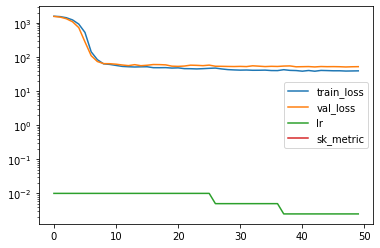

In [6]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [7]:
#find the longest molecule

ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
longest molecule length:  23


(array([6., 1., 1., 1., 1.], dtype=float32), [], [])

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.590222
epoch: 0, lr: 0.01
train loss: 66.20365624678762, val loss: 44.97372531890869
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:14.229347
epoch: 5, lr: 0.01
train loss: 3.1109851661481356, val loss: 2.7039968967437744
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:26.306851
epoch: 10, lr: 0.01
train loss: 2.1163070892032825, val loss: 2.0828402042388916
sklearn train metric: 0, sklearn validation metric: 0

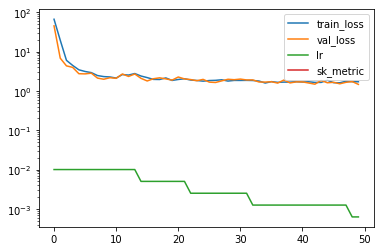

In [8]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  1
QM9 molecules scanned:  10001
QM9 molecules created:  10001
QM9 molecules scanned:  20001
QM9 molecules created:  20001
QM9 molecules scanned:  30001
QM9 molecules created:  30001
QM9 molecules scanned:  40001
QM9 molecules created:  40001
QM9 molecules scanned:  50001
QM9 molecules created:  50001
QM9 molecules scanned:  60001
QM9 molecules created:  60001
QM9 molecules scanned:  70001
QM9 molecules created:  70001
QM9 molecules scanned:  80001
QM9 molecules created:  80001
QM9 molecules scanned:  90001
QM9 molecules created:  90001
QM9 molecules scanned:  100001
QM9 molecules created:  100001
QM9 molecules scanned:  110001
QM9 molecules created:  110001
QM9 molecules scanned:  120001
QM9 molecules created:  120001
QM9 molecules scanned:  130001
QM9 molecules created:  130001
total uncharacterized molecules removed:  3054
total QM9 molecules created:  130831
CDataset created...
CModel loaded...
FFNet model loa

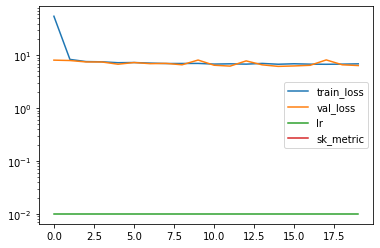

In [2]:
model_params = {'D_in': 29*29+11+29,
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {#'n': 10000, 
                              'features': ['A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [], 
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': None,
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  0
QM9 molecules scanned:  10001
QM9 molecules created:  1853
QM9 molecules scanned:  20001
QM9 molecules created:  4109
QM9 molecules scanned:  30001
QM9 molecules created:  5164
QM9 molecules scanned:  40001
QM9 molecules created:  8487
QM9 molecules scanned:  50001
QM9 molecules created:  10694
QM9 molecules scanned:  60001
QM9 molecules created:  15309
QM9 molecules scanned:  70001
QM9 molecules created:  20609
QM9 molecules scanned:  80001
QM9 molecules created:  25898
QM9 molecules scanned:  90001
QM9 molecules created:  32036
QM9 molecules scanned:  100001
QM9 molecules created:  38581
QM9 molecules scanned:  110001
QM9 molecules created:  46307
QM9 molecules scanned:  120001
QM9 molecules created:  54330
QM9 molecules scanned:  130001
QM9 molecules created:  58020
total uncharacterized molecules removed:  467
total QM9 molecules created:  57590
CDataset created...
CModel loaded...
FFNet model loaded...
lea

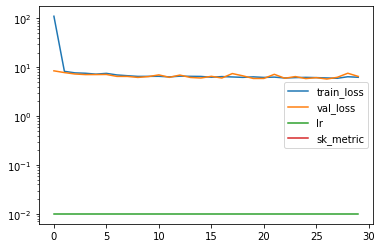

In [3]:
model_params = {'D_in': 29*29+29+11, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {#'n': 10000,
                              'features': ['A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': ('n_atoms','>','18'),
                              'use_pickle': False,
                              'flatten': True}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=30)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:03.583985
epoch: 0, lr: 0.01
train loss: 564.3501012465533, val loss: 530.2711385091146
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:15.539470
epoch: 4, lr: 0.01
train loss: 58.3115763944738, val loss: 64.48077011108398
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:27.791470
epoch: 8, lr: 0.01
train loss: 35.44275710161995, val loss: 34.3715934753418
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:33.807375
epoch: 10, lr: 0.01
train loss: 34.64882727230297, val loss: 33.9962412516276
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:45.828340
epoch: 14, lr: 0.01
train loss: 38.596714468563306, val loss: 32.55275281270345
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:57.877332
epoch

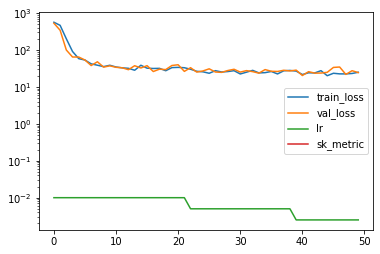

In [9]:
model_params = {'D_in': 63*63+63*32, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=50)